In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [3]:
df = pd.read_csv("dataset_clear.csv")

In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [5]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges"],axis=1)
y = df[target]



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8)

In [7]:
dummy = DummyRegressor()

In [8]:
numerical_features = [
       'age','bmi'
       ]
categorical_features = [
       'sex' , 'smoker', 'region','children'
       ]



In [9]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(),categorical_features),
    
])



In [10]:
X_train.head()

,age,sex,bmi,children,smoker,region
1113,23,male,24.510,0,no,northeast
967,21,male,25.745,2,no,northeast
598,52,female,37.525,2,no,northwest
170,63,male,41.470,0,no,southeast
275,47,female,26.600,2,no,northeast


In [11]:
dummy.fit(X_train,y_train)
dummy.score(X_test,y_test)





-0.008391982350864469

In [12]:
modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2),PolynomialFeatures(degree=3), Lasso(alpha=100,random_state=0))
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)


/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+08, tolerance: 1.464e+07
  model = cd_fast.enet_coordinate_descent(


0.8425877128714205

In [13]:
modelLasso.score(X_test,y_test)

0.8838148932629775

In [14]:
# train_sizes, train_scores, test_scores= learning_curve(modelLasso,X_train,y_train,cv=2)
                                           
                                           
# plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
# plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()
# plt.show()

In [15]:
y_pred = modelLasso.predict(X_train)

In [16]:
residual = (y_pred - y_train).abs().sort_values()

In [17]:
residual.describe()

count     1069.000000
mean      2833.099478
std       3679.437883
min          0.514829
25%       1060.011277
50%       1786.399580
75%       2445.225185
max      30888.642459
Name: charges, dtype: float64

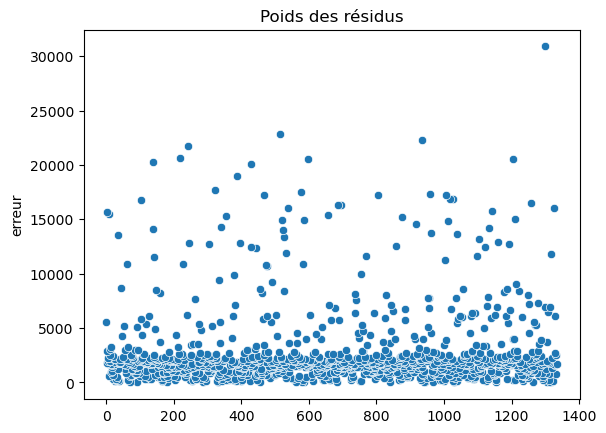

In [18]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [19]:


residual.quantile(0.98)



16204.90985671371

In [20]:
to_drop = residual[residual > residual.quantile(0.98)].index

In [21]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [22]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.849e+07, tolerance: 1.370e+07
  model = cd_fast.enet_coordinate_descent(


0.8938562050034102

In [23]:


modelLasso.score(X_test,y_test)



0.8854312378356148

In [24]:
y_pred = modelLasso.predict(X_train)

In [25]:
residual = (y_pred - y_train).abs().sort_values()

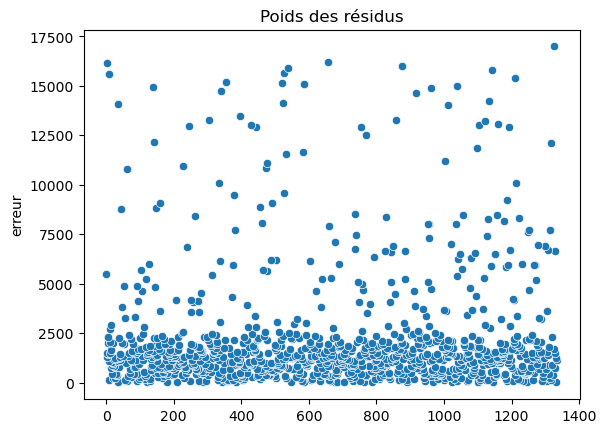

In [26]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [27]:
# train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(modelLasso,X_train,y_train,cv=5,return_times=True)
                                           
                                           
# plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
# plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()
# plt.show()